## Estilização da Saída do Markdown

In [1]:
%%HTML
<style>
  @import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

  body {
    font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
    line-height: 1.67;
  }
</style>


# Simulador de um Conversor Buck com CPL (Carga de Potência Constante)

## Descrição

Este notebook apresenta a implementação da modelagem matemática e do controlador de uma microrrede de corrente contínua, representada por um conversor buck com uma CPL (Carga de Potência Constante). O conversor buck é um dispositivo de conversão de potência que transforma uma tensão contínua de alta para baixa. A CPL é uma carga que demanda potência constante, independentemente da variação na tensão de entrada.

Para a implementação, serão utilizadas as bibliotecas Python Control, NumPy e Matplotlib. A modelagem matemática detalhada pode ser encontrada no documento separado chamado ["Mathematical Modeling of a Microgrid"](../docs/Mathematical%20Modeling%20of%20a%20Microgrid.md), localizado no diretório `docs`. Durante a implementação, serão explorados o sistema não linear, o sistema não linear transladado e o sistema linearizado, todos derivados da modelagem matemática.

### Data de Criação

2023-12-21

### Data de Modificação

2024-02-02

## Autor

Andevaldo da Encarnação Vitório  ([andevaldo.vitorio@icomp.ufam.edu.br](mailto:andevaldo.vitorio@icomp.ufam.edu.br))

## Orientador

Iury Valente de Bessa ([iury@ufam.edu.br](mailto:iury@ufam.edu.br))


## 1. Importação de Bibliotecas e Implementação de Funções Utilitárias

O código apresentado no início do tópico realiza a importação de diversas bibliotecas que serão utilizadas ao longo do desenvolvimento. Cada biblioteca possui um papel específico e contribui para o funcionamento do código:

- [`numpy`](https://numpy.org/): Biblioteca fundamental para manipulação de arrays e matrizes em Python. É utilizada para realizar cálculos matemáticos e operações com dados numéricos.
- [`matplotlib.pyplot`](https://matplotlib.org/): Biblioteca para criação de visualizações gráficas, como gráficos e diagramas. Permite a plotagem de dados e resultados de forma interativa e customizável.
- [`control`](https://python-control.readthedocs.io/): Biblioteca específica para análise e controle de sistemas dinâmicos. Fornece ferramentas para modelagem, simulação e análise de sistemas lineares e não lineares.

`ct.use_fbs_defaults()` define configurações padrão para o módulo `control`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import control.optimal as opt
from control.matlab import *
import cvxpy as cp
import math
ct.use_fbs_defaults()

In [3]:
def show_matrix(name, matrix, decimal_places=2):
  """
  Apresenta uma matriz com a quantidade de casas decimais desejadas.

  Parâmetros:
  ---
  - matrix: numpy.ndarray, a matriz a ser apresentada.
  - casas_decimais: int, o número de casas decimais desejadas (padrão é 2).
  """
  pattern = "{:." + str(decimal_places) + "e}"

  def format_elem(elem):
    return pattern.format(elem)

  width = [max(map(len, map(format_elem, coluna))) for coluna in matrix.T]

  print(name, "=")

  nspaces = sum(width) + 2 * matrix.shape[1]

  print("    ┌" + " " * nspaces + "┐")
  for line in matrix:
    formatted_line = "  ".join(format_elem(e).rjust(largura)
                               for e, largura in zip(line, width))
    print("    │ " + formatted_line + " │")
  print("    └" + " " * nspaces + "┘")
  print()

In [4]:
def format_value(value, precision=1):
  return "{:.{}e}".format(value, precision)

In [5]:
bold_ansi = '\033[1m'
cyan_ansi = '\033[96m'
red_ansi = '\033[91m'
green_ansi = '\033[92m'
yellow_ansi = '\033[93m'
blue_ansi = '\033[94m'
magenta_ansi = '\033[95m'
white_ansi = '\033[97m'
reset = '\033[0m'

In [6]:
bold_ansi = ''
cyan_ansi = ''
red_ansi = ''
green_ansi = ''
yellow_ansi = ''
blue_ansi = ''
magenta_ansi = ''
white_ansi = ''
reset = ''

## 2. Descrição do Sistema e Circuito

O sistema a seguir foi projetado para simplificar a representação de uma microrrede, visando facilitar cálculos e análises. Composto por um conversor buck e uma CPL configurada como carga de potência constante, representada por uma fonte de corrente, o sistema oferece uma abordagem eficiente para modelar o comportamento da microrrede.

<p align="center">
  <img src="../assets/imgs/main/buck_conversor_with_cpl_circuit.svg" alt="Circuito Elétrico do Sistema" style="max-width:100%; height:260px;"/>
</p>

No circuito apresentado:

- $R_L, \space R_C, \space C, \space L$: Resistores, capacitor e indutor do circuito.
- $d$: Duty Cycle
- $I_{CPL}$: Corrente da CPL
- $V_{in}$: Tensão de entrada.
- $V_{out}$: Tensão de entrada.

Neste circuito, $I_{CPL}$ depende da tensão do capacitor $v_C$ e da potência da CPL:

$$ I_{CPL} = \frac{P_{CPL}}{v_C}$$

## 3. Modelo Não-linear do Sistema
O modelo matemático adotado para o conversor buck baseia-se no modelo médio do sistema. Embora os conversores sejam naturalmente não-lineares, é comum empregar modelos de pequenos sinais (SSMs) para linearizar a representação em torno do ponto operacional (OP), considerando as situações de chave fechada e aberta.

### 3.1 Chave Fechada

Nesta configuração, a chave do conversor está fechada. O circuito é equivalente a um circuito série com uma fonte de tensão, um resistor e uma indutância. Durante este estado, as equações descrevem a variação da corrente $i_L$ no indutor e a tensão $v_C$ no capacitor.

<p align="center">
  <img src="../assets/imgs/main/buck_conversor_with_cpl_circuit_m1.svg" alt="Circuito Elétrico do Sistema" style="max-width:100%; height:260px;"/>
</p>

O modelo para a chave fechada é:

<br>

$$
\begin{equation}
  \tag{1.1} 
  M_{F}: \space
  \begin{cases}
    \frac{d}{dt}i_L &= \frac{R_L}{L} i_L - \frac{1}{L} v_C \\ \\
    \frac{d}{dt} v_C &= \frac{1}{C} i_L - \frac{1}{C R_C} v_C - \frac{1}{C v_C} P_{CPL}
  \end{cases}
\end{equation}
$$

<br>

### 3.2 Chave Aberta

Na situação em que a chave está aberta, o circuito é desconectado da fonte de tensão.

<p align="center">
  <img src="../assets/imgs/main/buck_conversor_with_cpl_circuit_m2.svg" alt="Circuito Elétrico do Sistema" style="max-width:100%; height:260px;"/>
</p>

O modelo para a chave aberta é:

$$
\begin{equation}
  M_{A}: \space
  \tag{1.2} 
  \begin{cases}
    \frac{d}{dt}i_L &= \frac{V_{in}}{L} d - \frac{R_L}{L} i_L - \frac{1}{L} v_C \\ \\
    \frac{d}{dt} v_C &= \frac{1}{C} i_L - \frac{1}{C R_C} v_C - \frac{1}{C v_C} P_{CPL}
  \end{cases}
\end{equation}
$$

### 3.3 Modelo Médio do Sistema

Baseado nas equações anteriores, o modelo médio do sistema é representado pelas equações diferenciais abaixo:

<br>

$$
\begin{equation}
MMS: \space
\tag{2} 
\begin{cases}
\frac{d}{dt}i_L &= \frac{V_{in}}{L} d - \frac{R_L}{L} i_L - \frac{1}{L} v_C \\ \\
\frac{d}{dt} v_C &= \frac{1}{C} i_L - \frac{1}{C R_C} v_C - \frac{1}{C v_C} P_{CPL}
\end{cases}
\end{equation}
$$

<br>


### 3.4 Implementação do Modelo Não-linear

#### 3.4.1 Definição de Funções de Atualização e Saída

Definição de uma função de atualização (para o lado direito da equação diferencial) e de uma função de saída (calcula as saídas a partir do estado)


In [7]:
def update_nonlinear(t, x, u, params):
  """
  Atualiza o sistema dinâmico não linear.

  Parâmetros:
  ----------
  - t: tempo
  - x: estados do sistema
  - u: entradas do sistema
  - params: parâmetros do sistema

  Retorna:
  ----------
  - dx: derivadas dos estados
  """
  # Definição dos parâmetros do sistema
  V_IN = params.get('Vin')   # Tensão de Entrada
  RL = params.get('rl')     # Resistência (indutor)
  RC = params.get('rc')     # Resistência (capacitor)
  L = params.get('L')       # Indutância
  C = params.get('C')       # Capacitância

  # Definição das entradas do sistema
  D, P_CPL = u     # Duty Cycle e Potência da CPL, respectivamente

  # Definição dos estados do sistema
  IL, VC = x      # Corrente do indutor e tensão do capacitor, respectivamente

  # Atualização
  dIl = (V_IN / L) * D - (RL / L) * IL - VC / L      # Corrente do indutor
  dVc = IL / C - VC / (C * RC) - P_CPL / (C * VC)    # Tensão do capacitor

  dx = np.array([dIl, dVc])

  return dx


def system_output(t, x, u, params):
  """
  Calcula a saída do sistema.

  Parâmetros:
  - t: tempo
  - x: estados do sistema
  - u: entradas do sistema
  - params: parâmetros do sistema

  Retorna:
  - y: saída do sistema
  """
  return x[0:2]


# Definição do sistema não-linear
nonlinear_system = ct.NonlinearIOSystem(
    update_nonlinear, system_output,
    name='nonlinear_system ',
    inputs=('D', 'P_CPL'),
    outputs=('IL', 'VC'),
    states=('IL', 'VC')
)

## 4. Modelo Não-linear Trasladado

### 4.1 O Ponto de Operação

Ao adentrarmos no Modelo do Sistema Transladado, é importante primeiro definir as variáveis de estado e os valores de operação. Essas definições serão usadas para descrever o comportamento do sistema transladado.

Dada a condição de operação $P_O = \left( \overline{i_L}, \space \overline{V_C}, \space \overline{d}, \space \overline{P_{CPL}} \right) $, os estados e as entradas do sistema pode ser decompostos em termos fixos e em termos variantes no tempo.

<br>

$$
X: \space
\begin{cases}
  i_L(t) &= \overline{i_L} + \delta i_L(t) \\
  v_C(t) &= \overline{V_C} + \delta V_C(t) 
\end{cases}
, \space \space \space \space \space
U: \space
\begin{cases}
  d(t) &= \overline{d} + \delta d(t) \\
  P_{CPL}(t) &= \overline{P_{CPL}} + \delta P_{CPL}(t)
\end{cases}
$$

<br>

Além disto, as derivadas temporais das variáveis de estado também são representadas por:

<br>

$$
\dot{X}: \space
\begin{cases}
  \dot{i_L} &= \overline{\dot{i_L}} + \delta \dot{i_L} \\
  \dot{v_C} &= \overline{\dot{V_C}} + \delta \dot{V_C} 
\end{cases}
$$

<br>

Para a modelagem da dinâmica do sistema, são definidas as seguintes funções a partir da __Equação 3.3__:

<br>

$$
\begin{cases}
  f(i_L, \space v_C, \space d, \space P_{CPL}) = \dot{i_L} = - \frac{R_L}{L} i_L - \frac{1}{L} v_C + \frac{V_{in}}{L} d \\
  g(i_L, \space v_C, \space d, \space P_{CPL}) = \dot{v_C} = - \frac{1}{C R_C} v_C + \frac{1}{C} i_L - \frac{1}{C v_C} P_{CPL}
\end{cases}
$$

<br>

Importante notar que, sob condições de operação em regime permanente, as funções no ponto de operação são ambas nulas

<br>

$$ f(P_O) = g(P_O) = 0 $$

<br>

Além disto, os pontos fixos das derivadas temporais dos estado também são nulas:

<br>

$$ \overline{\dot{i_L}} = \overline{\dot{v_C}} = 0 $$

<br>

Com base nisso, é possível determinar o duty cycle $d$ e a corrente do indutor $i_L$ no ponto de operação utilizando a tensão do capacitor e a potência da CPL nesse ponto específico.

<br>

$$ 
\overline{i_L} = \frac{1}{R_C} \overline{v_C} + \frac{1}{\overline{v_C}} \overline{P_{CPL}}
\space , \hspace{1cm}
\overline{d} = \frac{R_L}{V_{in}} \overline{i_L} + \frac{\overline{v_C}}{V_{in}} 
\tag{4.1.1}
$$


<br>

### 4.2 Modelo Matemático

Portanto, o sistema transladado, considerando o ponto de operação $P_O = \left( \overline{i_L}, \space \overline{V_C}, \space \overline{d}, \space \overline{P_{CPL}} \right) $, é:

<br>

$$
\begin{equation}
M_{transladado}: \space
\tag{4.3} 
\begin{cases}
\delta \dot{i_L} &= - \displaystyle\frac{R_L}{L} \delta i_L - \displaystyle\frac{1}{L} \delta v_C  + \displaystyle\frac{V_{in}}{L} \delta d
\\ \\
\delta \dot{v_C} &= - \displaystyle\frac{1}{C R_C} \delta v_C  + \displaystyle\frac{1}{C}  \delta i_L + \displaystyle\frac{\overline{P_{CPL}} \delta v_C - \overline{v_C} \delta P_{CPL}}{C \overline{v_C} \left(\overline{v_C} + \delta v_C\right)} 
\end{cases}
\end{equation}
$$
<br>

### 4.3 Implementação do Modelo Não-linear Transladado

O código a seguir implementa o modelo não-linear transladado que descreve a dinâmica do sistema físico por meio da definição de um ponto de operação. Os parâmetros, entradas e estados do sistema são definidos, e a função de atualização `update_translated_nonlinear` contém as equações diferenciais que representam o comportamento dinâmico.

In [8]:
def update_translated_nonlinear(t, x, u, params):
  """
  Atualiza os estados do sistema não linear transladado.

  Parâmetros:
  - t: tempo
  - x: estados do sistema
  - u: entradas do sistema
  - params: parâmetros do sistema

  Retorna:
  - dx: derivadas dos estados do sistema
  """
  # Definição dos parâmetros do sistema
  V_IN = params.get('Vin')
  RL = params.get('rl')
  RC = params.get('rc')
  L = params.get('L')
  C = params.get('C')
  OP = params.get('op')

  # Definição das entradas do sistema
  δD, δP_CPL = u

  # Definição dos estados do sistema
  δIL, δVC = x

  # Atualização
  DELTA_IL_DOT = - (RL / L) * δIL - δVC / L + (V_IN / L) * δD
  DELTA_VC_DOT = - δVC / (C * RC) + δIL / C + \
      (OP['Pcpl'] * δVC - OP['Vc'] * δP_CPL) / \
      (C * OP['Vc'] * (OP['Vc'] + δVC))

  X_DOT = np.array([DELTA_IL_DOT, DELTA_VC_DOT])

  return X_DOT


def system_output(t, x, u, params):
  """
  Calcula a saída do sistema.

  Parâmetros:
  - t: tempo
  - x: estados do sistema
  - u: entradas do sistema
  - params: parâmetros do sistema

  Retorna:
  - y: saída do sistema
  """

  return x[:2]


translated_nonlinear_system = ct.NonlinearIOSystem(
    update_translated_nonlinear, system_output,
    name='translated_nonlinear_system',
    inputs=('δd', 'δPcpl'),
    outputs=('δIl', 'δVc'),
    states=('δIl', 'δVc')
)

## 5. Simulação dos Modelos Não-lineares

#### 5.1 Definição dos Parâmetros da Simulação

 Especificação e atribuição dos valores iniciais aos parâmetros necessários para realizar a simulação do sistema.

In [9]:
# Parâmetros do Circuito
params = {'Vin': 48, 'rl': 0.1, 'rc': 35,
          'L': 40e-3, 'C': 10e-6, 'op': {'Pcpl': 15, 'Vc': 24}}

# Tempo de Simulação
ti = 0
tf = 0.04
npts = 100000

timepts = np.linspace(ti, tf, npts)

# Cálculo da Corrente e Duty Cycle de Operação
op = params['op']
IL_OP = (op['Vc'] / params['rc']) + op['Pcpl'] / op['Vc']
D_OP = (params['rl'] * IL_OP) / params['Vin'] + op['Vc'] / params['Vin']

params['op']['Il'] = IL_OP
params['op']['d'] = D_OP

# Ponto de operação de cada entrada e estado do sistema
U_OP = np.array([params['op']['d'], params['op']['Pcpl']])
X_OP = np.array([params['op']['Il'], params['op']['Vc']])

# Entradas do Sistema
D = params['op']['d']
P_CPL = params['op']['Pcpl']
U = np.array([D, P_CPL])

# Estados Iniciais do Sistema
IL_INIT = 0.95 * params['op']['Il']
VC_INIT = 0.95 * params['op']['Vc']
X0 = np.array([IL_INIT, VC_INIT])

δU = U - U_OP
δX0 = X0 - X_OP

print('Parâmetros: ')
params

Parâmetros: 


{'Vin': 48,
 'rl': 0.1,
 'rc': 35,
 'L': 0.04,
 'C': 1e-05,
 'op': {'Pcpl': 15,
  'Vc': 24,
  'Il': 1.3107142857142857,
  'd': 0.5027306547619048}}

#### 5.2 Resposta do Sistema Não Linear

Implementação do sistema com um entrada e condições iniciais específicos a fim de obter o comportamento dinâmico do sistema não linear.

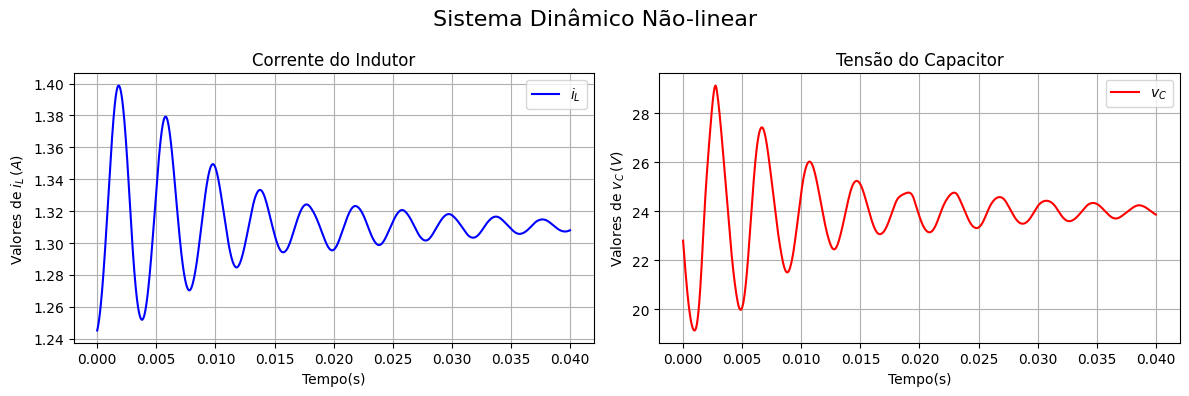

In [10]:
# Obtenção da saída
t, y_nonlinear = ct.input_output_response(
    sys=nonlinear_system, T=timepts,
    U=U.tolist(),
    X0=X0.tolist(),
    params=params
)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1 - Corrente do Indutor
axs[0].plot(t, y_nonlinear[0], linestyle='-', color='b', label='$i_L$')
axs[0].set_xlabel('Tempo(s)')
axs[0].set_ylabel('Valores de $i_L\,(A)$')
axs[0].set_title('Corrente do Indutor')
axs[0].legend()
axs[0].grid(True)

# Gráfico 2 - Tensão do Capacitor
axs[1].plot(t, y_nonlinear[1], linestyle='-', color='r', label='$v_C$')
axs[1].set_xlabel('Tempo(s)')
axs[1].set_ylabel('Valores de $v_C\,(V)$')
axs[1].set_title('Tensão do Capacitor')
axs[1].legend()
axs[1].grid(True)

fig.suptitle('Sistema Dinâmico Não-linear', fontsize=16)

plt.tight_layout()
plt.show()

### 5.3 Resposta do Sistema Não-linear Transladado

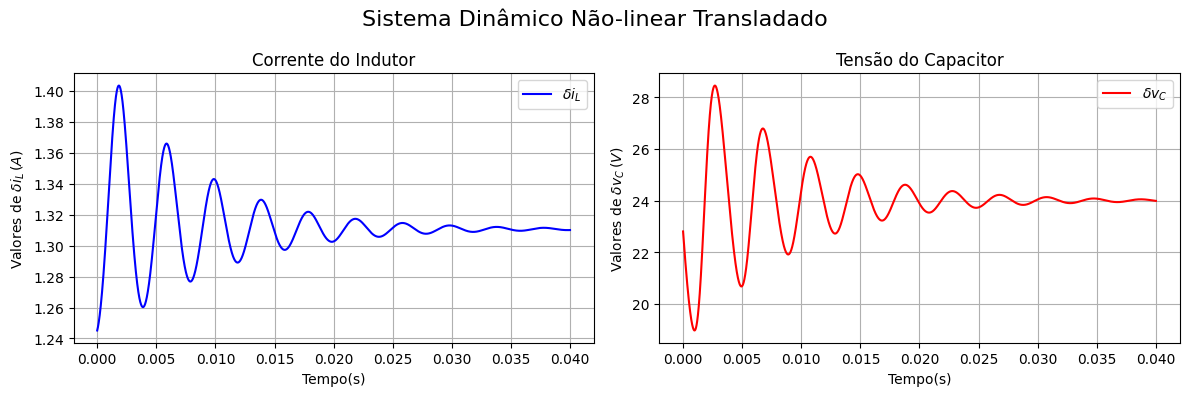

In [11]:
# Obtenção da Saída do Sistema Não-Linear Trasladado
t, y_translated_nonlinear = ct.input_output_response(
    sys=translated_nonlinear_system, T=timepts,
    U=δU.tolist(),
    X0=δX0.tolist(),
    params=params
)

# Criação e apresentação do gráfico
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1 - Corrente do Indutor
axs[0].plot(
    t,
    y_translated_nonlinear[0] + params['op']['Il'],
    linestyle='-', color='b', label='$\delta i_L$'
)

axs[0].set_xlabel('Tempo(s)')
axs[0].set_ylabel('Valores de $\delta i_L\,(A)$')
axs[0].set_title('Corrente do Indutor')
axs[0].legend()
axs[0].grid(True)

# Gráfico 2 - Tensão do Capacitor
axs[1].plot(
    t,
    y_translated_nonlinear[1] + params['op']['Vc'],
    linestyle='-', color='r', label='$\delta v_C$'
)

axs[1].set_xlabel('Tempo(s)')
axs[1].set_ylabel('Valores de $\delta v_C\,(V)$')
axs[1].set_title('Tensão do Capacitor')
axs[1].legend()
axs[1].grid(True)

fig.suptitle('Sistema Dinâmico Não-linear Transladado', fontsize=16)

plt.tight_layout()
plt.show()

## 6. Modelo do Sistema Linearizado

### 6.1 Descrição

O sistema linearizado, derivado a partir do sistema não linear, obtido na <a href="#section-3" style="color: #ffffff67; text-decoration: none;">Seção 3</a>, em torno dos pontos de operação, é representado por um conjunto de equações diferenciais lineares. Essas equações descrevem as variações no tempo das grandezas $\delta i_L$ e $\delta v_C$, que representam as alterações na corrente do indutor e na tensão do capacitor, respectivamente.

Baseado nisto, o sistema linearizado terá a forma:

$$
  \begin{cases}
    \frac{d}{dt} (\delta i_L) &= k_1 \cdot \delta i_L + k_2 \cdot \delta v_C + k_3 \cdot \delta d + k_4 \cdot \delta P_{CPL} \\ \\
    \frac{d}{dt} (\delta v_C) &= k_5 \cdot \delta i_L + k_6 \cdot \delta v_C + k_7 \cdot \delta d + k_8 \cdot \delta P_{CPL}
  \end{cases}
$$

Considerando as seguintes funções a seguir,

$$f(P) = \frac{d}{dt}i_L, \space\space\space\space  g(P) = \frac{d}{dt}v_C$$

onde $P = (i_L, \space v_C, \space d, \space P_{CPL})$, podemos obter os coeficientes $k$ com as seguintes derivadas parciais:
  
$$
k_1 = \dfrac{\partial f}{\partial i_L} \vert_{P = P_O}, \space \space
k_2 = \dfrac{\partial f}{\partial v_C} \vert_{P = P_O}, \space \space
k_3 = \dfrac{\partial f}{\partial d} \vert_{P = P_O}, \space \space
k_4 = \dfrac{\partial f}{\partial P_{CPL}} \vert_{P = P_O}
$$

$$
k_5 = \dfrac{\partial g}{\partial i_L} \vert_{P = P_O}, \space \space
k_6 = \dfrac{\partial g}{\partial v_C} \vert_{P = P_O}, \space \space
k_7 = \dfrac{\partial g}{\partial d} \vert_{P = P_O}, \space \space
k_8 = \dfrac{\partial g}{\partial P_{CPL}} \vert_{P = P_O}
$$

<br>

onde $P_O = (\overline{i_L}, \space \overline{v_C}, \space \overline{d}, \space \overline{P_{CPL}})$, é o ponto de operação definido na <a href="#section-4" style="color: #ffffff67; text-decoration: none;">Seção 4</a>. Desta forma, os termos são:

<br>

$$
k_1 = - \frac{R_L}{L}, \space\space\space\space
k_2 = - \frac{1}{L}, \space\space\space\space
k_3 = \frac{V_{in}}{L} , \space\space\space\space
k_4 = 0
$$

$$
k_5 = \frac{1}{C}, \space\space\space\space
k_6 = \frac{1}{C}\left(\frac{\overline{P_{CPL}}}{{{\overline{v_{C}}}^2}} - \frac{1}{R_C}\right), \space\space\space\space
k_7 = 0, \space\space\space\space
k_8 = - \frac{1}{C \overline{v_C}}
$$

<br>

Portanto, o sistema linearizado é:

<br>

$$
\begin{equation}
\tag{5.1}
  \begin{cases}
    \displaystyle \frac{d}{dt} (\delta i_L) &= \displaystyle - \frac{R_L}{L} \delta i_L - \frac{1}{L} \delta v_C + \frac{V_{in}}{L} \delta d 
    \\ \\
    \displaystyle  \frac{d}{dt} (\delta v_C) &= \displaystyle \frac{1}{C} \delta i_L + \frac{1}{C}\left(\frac{\overline{P_{CPL}}}{{\overline{{v_{C}}}^2}} - \frac{1}{R_C}\right) \delta v_C - \frac{1}{C \overline{v_C}} \delta P_{CPL}
  \end{cases}
\end{equation}
$$

ou,

$$
  \begin{bmatrix}
    \dot{\delta i_L} \\ \dot{\delta v_C}
  \end{bmatrix}
  =
  \begin{bmatrix}
    \displaystyle -\frac{R_L}{L} & \displaystyle -\frac{1}{L} \\ \\
    \displaystyle \frac{1}{C} & \displaystyle \frac{1}{C}\left(\frac{\overline{P_{CPL}}}{{{\overline{v_{C}}}^2}} - \frac{1}{R_C}\right)
  \end{bmatrix}
  \begin{bmatrix}
    \delta i_L \\ \delta v_C
  \end{bmatrix}
  +
  \begin{bmatrix}
    \displaystyle{\frac{V_{in}}{L}} & 0 \\ \\ 
    0 & \displaystyle{-\frac{1}{C\overline{v_C}}}
  \end{bmatrix}
  \begin{bmatrix}
    \delta d \\ \delta P_{CPL}
  \end{bmatrix}
$$

<br>

### 6.2 Implementação do Sistema Linearizado

O código a seguir implementa o modelo linearizado em torno de um ponto de operação. Os parâmetros, entradas e estados do sistema são definidos.

In [12]:
# definição das constantes
OP = params['op']
k1 = - (params['rl'] / params['L'])
k2 = - (1. / params['L'])
k3 = params['Vin'] / params['L']
k4 = 0.
k5 = 1. / params['C']
k6 = (1. / params['C']) * (OP['Pcpl'] /
                           (OP['Vc'] * OP['Vc']) - 1. / params['rc'])
k7 = 0.
k8 = - 1.0 / (params['C'] * OP['Vc'])

A = [[k1, k2], [k5, k6]]
B = [[k3, k4], [k7, k8]]
C = [[1., 0], [0., 1]]
D = [[0., 0.], [0., 0.]]

linearized_system = ct.ss2io(
    ss(A, B, C, D),
    name='linearized_system',
    inputs=('δd', 'δPcpl'),
    outputs=('δIl', 'δVc'),
    states=('δIl', 'δVc')
)

In [13]:
A

[[-2.5, -25.0], [99999.99999999999, -252.97619047619023]]

### 6.3 Simulação do Sistema Linearizado

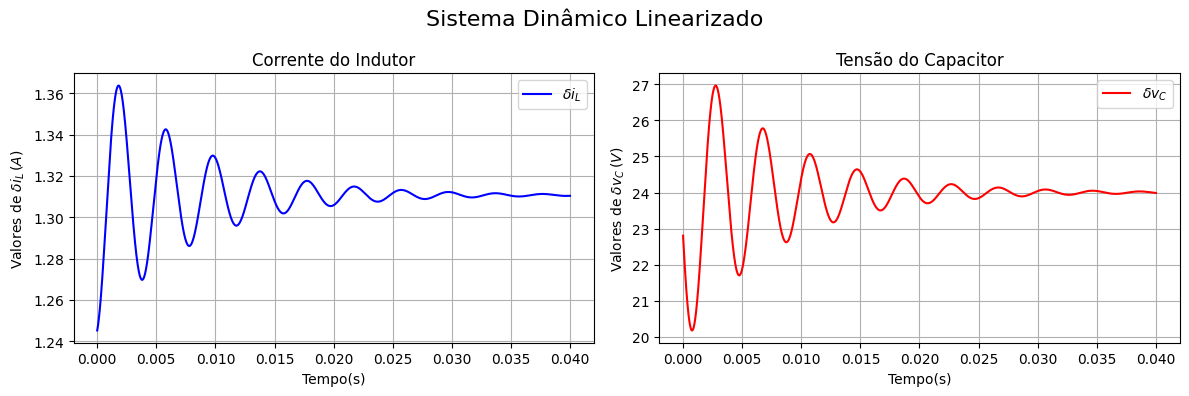

In [14]:
# Obtenção da Saída do Sistema Não-Linear Trasladado
t, y_linear = ct.input_output_response(
    sys=linearized_system, T=timepts,
    U=δU.tolist(),
    X0=δX0.tolist(),
)

# Criação e apresentação do gráfico
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1 - Corrente do Indutor
axs[0].plot(
    t,
    y_linear[0] + OP['Il'],
    linestyle='-', color='b', label='$\delta i_L$'
)

axs[0].set_xlabel('Tempo(s)')
axs[0].set_ylabel('Valores de $\delta i_L\,(A)$')
axs[0].set_title('Corrente do Indutor')
axs[0].legend()
axs[0].grid(True)

# Gráfico 2 - Tensão do Capacitor
axs[1].plot(
    t,
    y_linear[1] + OP['Vc'],
    linestyle='-', color='r', label='$\delta v_C$'
)

axs[1].set_xlabel('Tempo(s)')
axs[1].set_ylabel('Valores de $\delta v_C\,(V)$')
axs[1].set_title('Tensão do Capacitor')
axs[1].legend()
axs[1].grid(True)

fig.suptitle('Sistema Dinâmico Linearizado', fontsize=16)

plt.tight_layout()
plt.show()

#### 7. Comparação dos Resultados Obtidos na Simulação

Nesta seção, exploramos visualmente o comportamento do sistema através de gráficos. A biblioteca Matplotlib é utilizada para criar visualizações que representam a resposta do sistema ao longo do tempo.

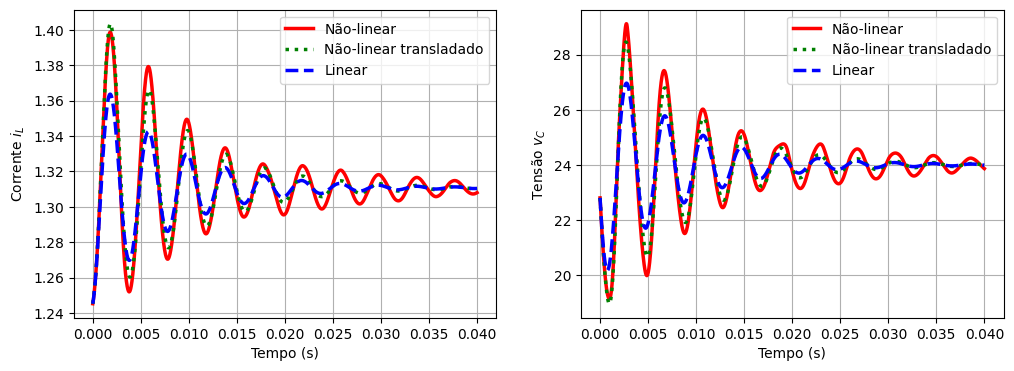

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
linewidth = 2.5

ax[0].plot(t, y_nonlinear[0],
           linestyle='-', color='r', linewidth=linewidth,
           label='Não-linear')

ax[0].plot(t, y_translated_nonlinear[0] + params['op']['Il'],
           linestyle=':', color='g', linewidth=linewidth,
           label='Não-linear transladado')

ax[0].plot(t, y_linear[0] + params['op']['Il'],
           linestyle='--', color='b', linewidth=linewidth,
           label='Linear')

ax[0].set_xlabel('Tempo (s)')
ax[0].set_ylabel('Corrente $i_L$')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(t, y_nonlinear[1],
           linestyle='-', color='r', linewidth=linewidth,
           label='Não-linear')

ax[1].plot(t, y_translated_nonlinear[1] + params['op']['Vc'],
           linestyle=':', color='g', linewidth=linewidth,
           label='Não-linear transladado')

ax[1].plot(t, y_linear[1] + params['op']['Vc'],
           linestyle='--', color='b', linewidth=linewidth,
           label='Linear')

ax[1].set_xlabel('Tempo (s)')
ax[1].set_ylabel('Tensão $v_C$')
ax[1].legend()
ax[1].grid(True)

## 7 Controladores $\mathscr{H}_2$ e $\mathscr{H}_{\infty}$

### 7.1 Obtenção de $K$ para minimização da norma $\mathscr{H}_2$ por meio de LMIs

#### 7.1.1 Descrição

Considerando o seguinte sistema linear invariante no tempo:

<br>

$$
\begin{cases}
\dot{x} &= Ax + B_2u + B_1w \\
y &= Cx + Du
\end{cases}
$$

<br>

onde, $x$ e $y$ são estados e saídas do sistema, respectivamente; e, $u$ e $w$ são entrada e pertubação dos sistema, respectivamente. Podemos obter a matriz $K$ que minimize a norma $\mathscr{H}_2$ por meio do seguinte problema de otimização:


$$ \underset{\displaystyle \rho, \space X = X^T, \space Z, \space W = W^T > 0}{\min} \space \space \rho $$

sujeito a

<br>

$$
\begin{bmatrix}
X & CW + DZ  \\
WC^T + Z^TD^T & W 
\end{bmatrix} 
> 0

, \hspace{0.67cm}

\rho \geq Tr(X)

, \hspace{0.67cm}

\begin{bmatrix}
AW + B_2Z + WA^T + Z^TB^T_2 & B_1 \\
B_1^T & -I 
\end{bmatrix} 
< 0
$$

<br>

com $K = ZW^{-1}$ e $\lVert H(s) \rVert ^2_2 = \rho^\star$.

Baseado no modelo linearizado obtido na Seção 6, podemos definir as matrizes A, B, C e D da seguinte forma:


<br>

$$
  A =
  \begin{bmatrix}
    \displaystyle -\frac{R_L}{L} & \displaystyle -\frac{1}{L} \\ \\
    \displaystyle \frac{1}{C} & \displaystyle \frac{1}{C}\left(\frac{\overline{P_{CPL}}}{{{\overline{v_{C}}}^2}} - \frac{1}{R_C}\right)
  \end{bmatrix}
  , \hspace{.5cm}
  B_2 = 
  \begin{bmatrix}
    \displaystyle{\frac{V_{in}}{L}} \\ \\ 
    0
  \end{bmatrix}
  , \hspace{.5cm}
  B_1 = 
  \begin{bmatrix}
    0 \\ \\ 
    \displaystyle{-\frac{1}{C\overline{v_C}}}
  \end{bmatrix}
  , \hspace{.5cm}
  C = 
  \begin{bmatrix}
    1 & 0 \\ \\ 
    0 & 1
  \end{bmatrix}
  , \hspace{.5cm}
  D = 0
$$

<br>

onde as variáveis do sistema são:

<br>

$$
x = 
\begin{bmatrix}
  \delta i_L \\ \delta v_C
\end{bmatrix}
, \hspace{.5cm}
u = \delta d
, \hspace{.5cm}
w = \delta P_{CPL}
$$

#### 7.1.2 Implementação da LMI

In [16]:
# Definição dos Parâmetros
n_outputs = linearized_system.noutputs
n_states = linearized_system.nstates
n_inputs = linearized_system.ninputs

A = cp.Parameter((n_states, n_states), value=linearized_system.A)
BW = cp.Parameter((n_states, 1), value=linearized_system.B[:, 1])
BU = cp.Parameter((n_states, 1), value=linearized_system.B[:, 0])
C = cp.Parameter((n_outputs, n_states), value=linearized_system.C)
D = cp.Parameter((n_outputs, 1), value=linearized_system.D[:, 0])
I = cp.Parameter((2, 2), name='I', value=np.identity(2))

# Definição das Variáveis
Ξ_TIL = cp.Variable((n_states, n_states), name='Ξ_TIL', PSD=True)
Ψ_TIL = cp.Variable((n_states, n_states), name='Ψ_TIL', PSD=True)
X = cp.Variable((n_states, n_states), name='X', PSD=True)
Q = cp.Variable((n_states, n_states), name='Q', PSD=True)
K_TIL = cp.Variable((1, n_states), name='K_TIL')

# Definição do Problema: Objetivo e Restrições
# Dúvida, somente variáveis controláveis?
obj = cp.Minimize(0)

M11 = A @ X + BU @ K_TIL + X @ A.T + K_TIL.T @ BU.T
M12 = BU @ K_TIL
M13 = X

M21 = K_TIL.T @ BU.T
M22 = -Ξ_TIL
M23 = np.zeros(shape=(n_states, n_states))

M31 = X
M32 = np.zeros(shape=(n_states, n_states))
M33 = -Ψ_TIL

M = cp.bmat([[M11, M12, M13],
             [M21, M22, M23],
             [M31, M32, M33]])

N11 = -Q
N12 = I
N21 = I.T
N22 = -X
N = cp.bmat([[N11, N12],
             [N21, N22]])

constraints = [M << 0]
prob = cp.Problem(obj, constraints)

# Resolução do Problema usando o solver MOSEK
prob.solve(solver=cp.MOSEK, verbose=False)

K1 = None
Ξ = None
Ψ = None

# Apresentação dos Resultados
if prob.status not in ["infeasible", "unbounded"]:
  print("Valor ótimo: %s\n" % prob.value)
  for variable in prob.variables():
    if len(variable.shape) == 2:
      show_matrix(variable.name(), variable.value)
    else:
      print(variable.name(), '=', variable.value, '\n')

  X_INV = np.linalg.inv(X.value)
  Ξ = X_INV @ Ξ_TIL.value @ X_INV

  K = K_TIL @ X_INV
  K1 = K.value

  show_matrix('K', K.value)

  Ψ = np.linalg.inv(Ψ_TIL.value)

  show_matrix('P', X_INV)
  show_matrix('Ξ', Ξ),
  show_matrix('Ψ', Ψ),
else:
  print('O problema não é factível')

np.linalg.eig(linearized_system.A)

Valor ótimo: 0.0

X =
    ┌                    ┐
    │ 1.53e-04  1.50e-03 │
    │ 1.50e-03  5.97e-01 │
    └                    ┘

K_TIL =
    ┌                      ┐
    │ -2.88e-04  -6.81e-06 │
    └                      ┘

Ξ_TIL =
    ┌                    ┐
    │ 9.87e-01  2.97e-03 │
    │ 2.97e-03  8.79e-01 │
    └                    ┘

Ψ_TIL =
    ┌                    ┐
    │ 8.79e-01  4.50e-04 │
    │ 4.50e-04  1.06e+00 │
    └                    ┘

K =
    ┌                     ┐
    │ -1.93e+00  4.85e-03 │
    └                     ┘

P =
    ┌                      ┐
    │  6.69e+03  -1.69e+01 │
    │ -1.69e+01   1.72e+00 │
    └                      ┘

Ξ =
    ┌                      ┐
    │  4.42e+07  -1.11e+05 │
    │ -1.11e+05   2.83e+02 │
    └                      ┘

Ψ =
    ┌                      ┐
    │  1.14e+00  -4.85e-04 │
    │ -4.85e-04   9.46e-01 │
    └                      ┘



EigResult(eigenvalues=array([-127.73809524+1576.17112634j, -127.73809524-1576.17112634j]), eigenvectors=matrix([[0.00125222+0.01575974j, 0.00125222-0.01575974j],
        [0.99987502+0.j        , 0.99987502-0.j        ]]))

In [17]:
K = [-1.93e+00, 4.85e-03]
zero = 0
events_time = []


def etm_output(t, x, u, params):
  global zero, events_time

  if t != etm_output.previous_time:
    etm_output.previous_time = t
    if t == 0.:
      zero += 1

  last_states_sent = u[0:2]
  current_states = u[2:4]

  error = last_states_sent - current_states
  Γ = current_states.T @ Ψ @ current_states - error.T @ Ξ @ error

  if zero == 1 and Γ < 0:
    events_time.append(t)

  # print(f'%.2e' % t)

  state_to_sent = (current_states if Γ < 0 or t == 0. else last_states_sent)
  return [Γ < 0, state_to_sent[0], state_to_sent[1]]


etm_output.previous_time = -1

ETM = ct.NonlinearIOSystem(
    None, etm_output,
    name='etm',
    inputs=('x1_hat', 'x2_hat', 'x1', 'x2'),
    outputs=('Γ', 'x1', 'x2'),
)


def zoh_output(t, x, u, params):
  if t != zoh_output.previous_time:
    zoh_output.lss = zoh_output.previous
    zoh_output.previous_time = t

  zoh_output.previous = u

  return zoh_output.lss


zoh_output.previous_time = 0
zoh_output.second_simulation = False
zoh_output.previous = []
zoh_output.lss = [0, 0]

ZOH = ct.ss(
    None, zoh_output,
    name='zoh',
    inputs=('x1', 'x2'),
    outputs=('x1_hat', 'x2_hat'),
    # states=1
)


def control_output(t, x, u, params):
  duty_cycle = K @ u
  return [duty_cycle]


CONTROL = ct.NonlinearIOSystem(
    None, control_output,
    name='control',
    inputs=('x1_hat', 'x2_hat'),
    outputs=('u'),
)

SYS = ct.interconnect(
    (linearized_system, ETM, ZOH, CONTROL),
    connections=(
        # Conexão entre a saída do controlador e a planta
        ('linearized_system.δd', 'control.u'),

        # Conexão entre as saídas do ZOH e da planta ao ETM
        ('etm.x1_hat', 'zoh.x1_hat'),
        ('etm.x2_hat', 'zoh.x2_hat'),
        ('etm.x1', 'linearized_system.δIl'),
        ('etm.x2', 'linearized_system.δVc'),

        # Conexão da saída do ETM no ZOH
        ('zoh.x1', 'etm.x1'),
        ('zoh.x2', 'etm.x2'),

        # Conexão da saída do ZOH no controlador
        ('control.x1_hat', 'zoh.x1_hat'),
        ('control.x2_hat', 'zoh.x2_hat'),
    ),
    name='conversor_system',
    inplist=('linearized_system.δPcpl'),
    outlist=('linearized_system.δIl',
             'linearized_system.δVc',
             'etm.Γ',
             'linearized_system.δd',
             #  'zoh.x1_hat',
             #  'zoh.x2_hat'
             ),
    output=('δIl', 'δVc', 'Γ', 'u')
)

print(SYS)
print('')

step = 1e-9
timepts = np.arange(0, 0.02 + step, step)
t, y = ct.input_output_response(
    sys=SYS, T=timepts,
    U=[0],
    X0=δX0,
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step}
)

<InterconnectedSystem>: conversor_system
Inputs (1): ['u[0]']
Outputs (4): ['δIl', 'δVc', 'Γ', 'u']
States (2): ['linearized_system_δIl', 'linearized_system_δVc']



KeyboardInterrupt: 

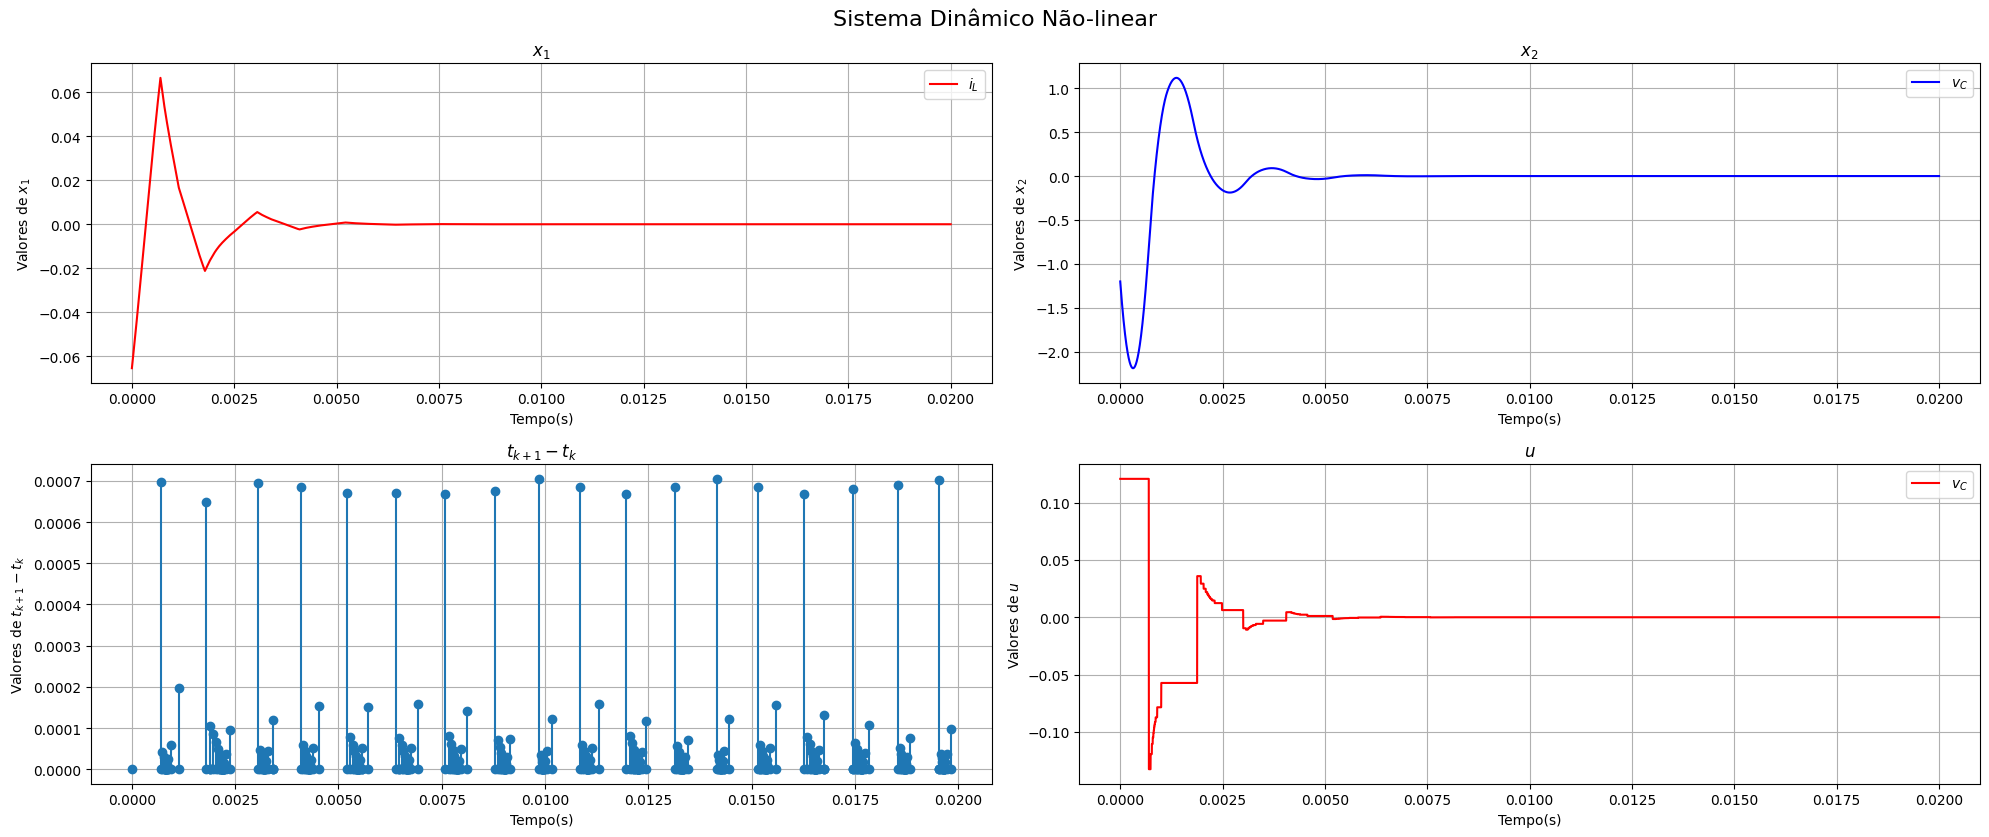

In [ ]:
tk_time = []
tk_value = []

# last_triggered_time = None
# for i in range(len(t)):
#   if y[2][i]:
#     if last_triggered_time is not None:
#       tk_time.append(last_triggered_time)
#       tk_value.append(t[i] - last_triggered_time)
#     last_triggered_time = t[i]

# print(tk_value)

for i in range(1, len(events_time)):
  tk_time.append(events_time[i])
  tk_value.append(events_time[i] - events_time[i-1])

fig, axs = plt.subplots(2, 2, figsize=(20, 8.5))

# Gráfico 1
axs[0][0].plot(t, y[0], linestyle='-', color='r', label='$i_L$')
axs[0][0].set_xlabel('Tempo(s)')
axs[0][0].set_ylabel('Valores de $x_1$')
axs[0][0].set_title('$x_1$')
axs[0][0].legend()
axs[0][0].grid(True)

# Gráfico 2
axs[0][1].plot(t, y[1], linestyle='-', color='b', label='$v_C$')
axs[0][1].set_xlabel('Tempo(s)')
axs[0][1].set_ylabel('Valores de $x_2$')
axs[0][1].set_title('$x_2$')
axs[0][1].legend()
axs[0][1].grid(True)

# Gráfico 3
axs[1][0].stem(tk_time, tk_value, basefmt=' ')
axs[1][0].set_xlabel('Tempo(s)')
axs[1][0].set_ylabel('Valores de $t_{k+1}-t_k$')
axs[1][0].set_title('$t_{k+1}-t_k$')
axs[1][0].grid(True)

# axs[1][0].stem(t, y[2], basefmt=' ')
# axs[1][0].set_xlabel('Tempo(s)')
# axs[1][0].set_ylabel('Valores de $t_{k+1}-t_k$')
# axs[1][0].set_title('$t_{k+1}-t_k$')
# axs[1][0].grid(True)

# Gráfico 4
axs[1][1].plot(t[1:], y[3][1:], linestyle='-', color='r', label='$v_C$')
axs[1][1].set_xlabel('Tempo(s)')
axs[1][1].set_ylabel('Valores de $u$')
axs[1][1].set_title('$u$')
axs[1][1].legend()
axs[1][1].grid(True)

fig.suptitle('Sistema Dinâmico Não-linear', fontsize=16)

plt.tight_layout()
plt.show()